# Visualize dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from data import get_data

In [2]:
url = "https://obj.umiacs.umd.edu/eventprediction/transactions.tgz"
train_test_split_year = 2018
sample_size = 10
consider_card = False
trainset, testset = get_data(
    url, train_test_split_year, sample_size, consider_card, save_csv=True
)

Checking c:\Users\monte\code\event_prediction\data\transactions.tgz to extract files...
Extracted files: ['c:\\Users\\monte\\code\\event_prediction\\data\\card_transaction.v1.csv']
Doing basic preprocessing...


c:\Users\monte\code\event_prediction\data.py:92: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X["Amount"] = X["Amount"].str.replace("$", "").astype(float)
C:\Users\monte\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\monte\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Splitting into train and test sets...
Adding train transactions to test set...
Adding static user fields...
Saving train and test sets to csv...


In [3]:
trainset.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,...,MCC,Errors?,Is Fraud?,Hour,total_minutes,rownumber,avg_dollar_amt,std_dollar_amt,top_mcc,top_chip
0,0,0,2002,9,1,06:21,4.898511,Swipe Transaction,3527213246127876953,La Verne,...,5300,NaN,No,6,17181021,0,4.124234,0.970711,5411,Swipe Transaction
1,0,0,2002,9,1,06:42,3.650139,Swipe Transaction,-727612092139916043,Monterey Park,...,5411,NaN,No,6,17181042,1,4.124234,0.970711,5411,Swipe Transaction
2,0,0,2002,9,2,06:22,4.790321,Swipe Transaction,-727612092139916043,Monterey Park,...,5411,NaN,No,6,17182462,2,4.124234,0.970711,5411,Swipe Transaction
3,0,0,2002,9,2,17:45,4.859425,Swipe Transaction,3414527459579106770,Monterey Park,...,5651,NaN,No,17,17183145,3,4.124234,0.970711,5411,Swipe Transaction
4,0,0,2002,9,3,06:23,4.651195,Swipe Transaction,5817218446178736267,La Verne,...,5912,NaN,No,6,17183903,4,4.124234,0.970711,5411,Swipe Transaction


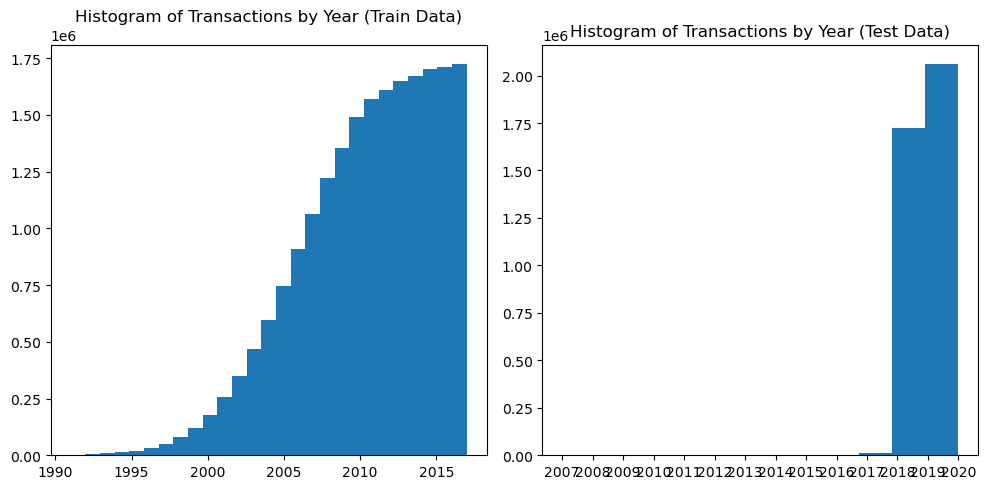

In [4]:
# Visualize the distribution of transactions for train and test sets
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(trainset['Year'], bins=len(trainset['Year'].unique()))
plt.title('Histogram of Transactions by Year (Train Data)')

plt.subplot(1, 2, 2)
plt.hist(testset['Year'], bins=len(testset['Year'].unique()))
plt.title('Histogram of Transactions by Year (Test Data)')
plt.xticks(np.arange(min(testset['Year']), max(testset['Year'])+1, 1))

plt.tight_layout()
plt.show()

In [5]:
print(trainset.duplicated().any())
print(testset.duplicated().any())
print(f'Train size: {trainset.shape}, test size: {trainset.shape}')
print('train nan:\n', trainset.isnull().any())
print('test nan:\n', testset.isnull().any())

False
False
Train size: (20604847, 22), test size: (20604847, 22)
train nan:
 User              False
Card              False
Year              False
Month             False
Day               False
Time              False
Amount             True
Use Chip          False
Merchant Name     False
Merchant City     False
Merchant State     True
Zip                True
MCC               False
Errors?            True
Is Fraud?         False
Hour              False
total_minutes     False
rownumber         False
avg_dollar_amt    False
std_dollar_amt     True
top_mcc           False
top_chip          False
dtype: bool
test nan:
 User              False
Card              False
Year              False
Month             False
Day               False
Time              False
Amount             True
Use Chip          False
Merchant Name     False
Merchant City     False
Merchant State     True
Zip                True
MCC               False
Errors?            True
Is Fraud?         False
Hour       